<a href="https://colab.research.google.com/github/arcweld/DSI_Capstone_2/blob/main/Capstone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Predictive Maintenance Project
This notebook explores a database created by NASA, the "Turbofan Engine Degradation Simulation Data Set", by appying a variety of machine learning models and developing an understanding of how such models could help in the predictive maintenance decision making process.

# Imports

In [3]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, balanced_accuracy_score
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
import itertools


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Modules and Helper Functions

### Data loading

In [4]:
DOWNLOAD_ROOT = 'https://ti.arc.nasa.gov/'
ENG_PATH = os.path.join('data','nasa_eng')
ENG_URL = DOWNLOAD_ROOT + 'c/6' 

def fetch_eng_data(eng_url=ENG_URL, eng_path=ENG_PATH):
    os.makedirs(eng_path, exist_ok=True)
    if not os.path.exists(os.path.join(eng_path,'CMAPSSData.zip')):
        zip_path = os.path.join(eng_path, 'CMAPSSData.zip')
        urllib.request.urlretrieve(eng_url, zip_path)
        eng_zip = zipfile.ZipFile(zip_path, 'r')
        eng_zip.extractall(path=eng_path)
        eng_zip.close()
        print('All files downloaded and extracted')
    else:
        print('All files in place')
        
    
def load_train_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/train_FD00{series_n}.txt', sep=' ', names=new_col)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    return df

    
def load_test_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/test_FD00{series_n}.txt', sep=' ', names=new_col, header=None)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    truth = pd.read_csv(f'data/nasa_eng/RUL_FD00{series_n}.txt', header=None, names=['eol'])
    truth['id'] = truth.index +1
    df = df.merge(truth, on=['id'], how='left')
    return df



### Data conditioning

In [5]:
def normalize_data(df1, *df2):
    scale = MinMaxScaler()
    scale.fit(df1.loc[:,'s1':'s21'])
    scale.transform(df1.loc[:,'s1':'s21'])
    if df2:
        scale.transform(df2.loc[:,'s1':'s21'])
        return df1, df2
    return df1

def add_labels(df):
    if 'eol' not in df.columns:
        fail = df.groupby('id').cycle.max()
        df['eol'] = df['id'].apply(lambda x: fail[x])

    df['RUL'] = df['eol'] - df['cycle']
    # df.drop('eol', axis=1, inplace=True)
    df['f30'] = df['RUL'].apply(lambda x: 2 if x <= 10 else 1 if x <=30 else 0)
    df['f10'] = df['RUL'].apply(lambda x: 1 if x <= 10 else 0)

    return df



### Test, train split

In [6]:
def tts(df0):
    df = df0.copy()

    n_eng = df['id'].unique()
    test_index = np.random.choice(n_eng, int(0.2*len(n_eng)))
    df_test = df[df['id'].isin(test_index)]
    df_test.sort_values(by =['id', 'cycle'])
    df_train = df[~df['id'].isin(test_index)]
    df_train.sort_values(by =['id', 'cycle'])

    return df_test, df_train 

def xy_split(df):
    X = df.drop(['RUL','f10','f30', 'eol'], axis=1)
    y_reg = df['RUL']
    y_clf = df['f10']
    y_mclf = df['f30']

    return X, y_reg, y_clf, y_mclf

### Windowing

In [7]:
def window_avg_sd(df0, win=10): 
    df = df0.copy()
    sensor = {f's{i}': [f'a{i}', f'sd{i}'] for i in range(1,22) }
    if 'a1' in df.columns: 
        print('DF previously transformed')
        return None
    for s, agg in sensor.items():
        for id in df.id.unique():
            avg = df[s].groupby(df['id']).rolling(window=win, min_periods=4).mean()
            sd = df[s].groupby(df['id']).rolling(window=win, min_periods=4).std()
        df.insert(len(df.columns), f'{agg[0]}', avg.values)
        df.insert(len(df.columns), f'{agg[1]}', sd.values)
    
    return df

def window_trending(df0, win=10):    
    df = df0.copy()
    sensor = {f's{i}': [f'a{i}', f'sd{i}', f'max{i}', f'min{i}', f'incr{i}', f'dec{i}'] for i in range(1,22) }
    if 'a1' in df.columns: 
        print('DF previously transformed')
        return None
    for s, agg in sensor.items():
        for id in df.id.unique():
            avg = df[s].groupby(df['id']).rolling(window=win, min_periods=4).mean()
            sd = df[s].groupby(df['id']).rolling(window=win, min_periods=4).std()
            max = df[s].groupby(df['id']).rolling(window=win, min_periods=4).max()
            min = df[s].groupby(df['id']).rolling(window=win, min_periods=4).min()
        df.insert(len(df.columns), f'{agg[0]}', avg.values)
        df.insert(len(df.columns), f'{agg[1]}', sd.values)
        df.insert(len(df.columns), f'{agg[2]}', max.values)
        df.insert(len(df.columns), f'{agg[3]}', min.values)

        df[agg[4]] = df[agg[0]] - df[agg[3]]
        df[agg[5]] = df[agg[2]] - df[agg[0]]

        df.dropna(inplace=True)

    return df


### Tensorflow

In [8]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]



# Load Data

In [9]:
fetch_eng_data()

All files downloaded and extracted


In [10]:
df1 = add_labels(load_train_data(1))
df_holdout = add_labels(load_test_data(1))


# Exploratory Data Analysis and Visualisation

## Quicklooks

### df1

In [11]:
df1.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol,RUL,f30,f10
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187,0,0


In [10]:
df1.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol,RUL,f30,f10
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,216.615724,107.807862,0.203577,0.053318
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,50.028600,68.880990,0.518442,0.224672
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,128.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,185.000000,51.000000,0.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,207.000000,103.000000,0.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,240.000000,155.000000,0.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,362.000000,361.000000,2.000000,1.000000


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

In [12]:
df1.eol.unique()

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 202, 168, 147, 230, 199, 156,
       165, 194, 191, 200, 181, 128, 216, 196, 256, 214, 231, 215, 198,
       213, 257, 193, 275, 137, 172, 185, 174, 283, 153, 313, 362, 208,
       166, 229, 210, 154, 293, 267, 278, 178, 217, 135, 341, 155, 258,
       336])

In [13]:
df1.eol.max(), df1.eol.min()

(362, 128)

### df2

In [22]:
df2.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol,RUL,f30,f10,a1,sd1,max1,min1,incr1,dec1,a2,sd2,max2,min2,...,max15,min15,incr15,dec15,a16,sd16,max16,min16,incr16,dec16,a17,sd17,max17,min17,incr17,dec17,a18,sd18,max18,min18,incr18,dec18,a19,sd19,max19,min19,incr19,dec19,a20,sd20,max20,min20,incr20,dec20,a21,sd21,max21,min21,incr21,dec21
63,1,64,0.0017,0.0002,100.0,518.67,642.23,1584.51,1400.11,14.62,21.61,553.88,2388.10,9043.67,1.3,47.45,521.82,2388.04,8128.15,8.4066,0.03,391,2388,100.0,38.93,23.3840,192,128,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.270,0.206128,642.6,641.9,...,8.4476,8.3878,0.03007,0.02973,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,391.7,1.159502,394.0,390.0,1.7,2.3,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.908571,0.077121,39.03,38.77,0.138571,0.121429,23.340525,0.049386,23.384,23.2707,0.069825,0.043475
64,1,65,-0.0000,0.0005,100.0,518.67,642.28,1584.72,1403.24,14.62,21.61,553.97,2388.03,9044.01,1.3,47.56,521.54,2388.13,8132.94,8.4406,0.03,392,2388,100.0,38.90,23.3752,192,127,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.257,0.200336,642.6,641.9,...,8.4476,8.3878,0.03342,0.02638,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,391.7,1.159502,394.0,390.0,1.7,2.3,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.907500,0.071464,39.03,38.77,0.137500,0.122500,23.347460,0.045494,23.384,23.2707,0.076760,0.036540
65,1,66,-0.0007,-0.0004,100.0,518.67,642.50,1588.50,1399.52,14.62,21.61,554.00,2388.06,9059.45,1.3,47.14,521.76,2388.05,8128.32,8.3911,0.03,391,2388,100.0,38.95,23.3152,192,126,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.258,0.201649,642.6,641.9,...,8.4476,8.3878,0.03231,0.02749,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,391.7,1.159502,394.0,390.0,1.7,2.3,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.912222,0.068333,39.03,38.77,0.142222,0.117778,23.342083,0.042769,23.384,23.2707,0.071383,0.041917
66,1,67,0.0016,-0.0004,100.0,518.67,642.33,1590.22,1403.02,14.62,21.61,554.31,2388.10,9050.24,1.3,47.39,522.64,2388.08,8134.07,8.3925,0.03,393,2388,100.0,38.97,23.2910,192,125,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.278,0.197417,642.6,641.9,...,8.4476,8.3878,0.02893,0.03087,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,391.8,1.229273,394.0,390.0,1.8,2.2,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.918000,0.066966,39.03,38.77,0.148000,0.112000,23.334786,0.043556,23.384,23.2707,0.064086,0.049214
67,1,68,-0.0018,0.0000,100.0,518.67,642.51,1582.06,1404.42,14.62,21.61,554.04,2388.10,9051.78,1.3,47.36,521.72,2388.07,8132.39,8.4242,0.03,392,2388,100.0,38.95,23.3174,192,124,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.339,0.157935,642.6,642.1,...,8.4476,8.3878,0.02816,0.03164,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,392.0,1.054093,394.0,391.0,1.0,2.0,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.920000,0.067659,39.03,38.77,0.150000,0.110000,23.332612,0.040791,23.384,23.2707,0.061912,0.051388


In [23]:
df2.columns[0:5]

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3'], dtype='object')

In [24]:
df2.columns[5:26]

Index(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'],
      dtype='object')

In [25]:
df2.columns[26:30]

Index(['eol', 'RUL', 'f30', 'f10'], dtype='object')

In [26]:
df2.columns[30:84]

Index(['a1', 'sd1', 'max1', 'min1', 'incr1', 'dec1', 'a2', 'sd2', 'max2',
       'min2', 'incr2', 'dec2', 'a3', 'sd3', 'max3', 'min3', 'incr3', 'dec3',
       'a4', 'sd4', 'max4', 'min4', 'incr4', 'dec4', 'a5', 'sd5', 'max5',
       'min5', 'incr5', 'dec5', 'a6', 'sd6', 'max6', 'min6', 'incr6', 'dec6',
       'a7', 'sd7', 'max7', 'min7', 'incr7', 'dec7', 'a8', 'sd8', 'max8',
       'min8', 'incr8', 'dec8', 'a9', 'sd9', 'max9', 'min9', 'incr9', 'dec9'],
      dtype='object')

In [27]:
df2.columns[84:]

Index(['a10', 'sd10', 'max10', 'min10', 'incr10', 'dec10', 'a11', 'sd11',
       'max11', 'min11', 'incr11', 'dec11', 'a12', 'sd12', 'max12', 'min12',
       'incr12', 'dec12', 'a13', 'sd13', 'max13', 'min13', 'incr13', 'dec13',
       'a14', 'sd14', 'max14', 'min14', 'incr14', 'dec14', 'a15', 'sd15',
       'max15', 'min15', 'incr15', 'dec15', 'a16', 'sd16', 'max16', 'min16',
       'incr16', 'dec16', 'a17', 'sd17', 'max17', 'min17', 'incr17', 'dec17',
       'a18', 'sd18', 'max18', 'min18', 'incr18', 'dec18', 'a19', 'sd19',
       'max19', 'min19', 'incr19', 'dec19', 'a20', 'sd20', 'max20', 'min20',
       'incr20', 'dec20', 'a21', 'sd21', 'max21', 'min21', 'incr21', 'dec21'],
      dtype='object')

In [28]:
trim_col = np.array(df2.describe().loc['std',:]!=0)
df2.loc[:,trim_col]

,id,cycle,setting1,setting2,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s20,s21,eol,RUL,f30,f10,a1,max1,min1,a2,sd2,max2,min2,incr2,dec2,a3,sd3,max3,min3,...,dec12,a13,sd13,max13,min13,incr13,dec13,a14,sd14,max14,min14,incr14,dec14,a15,sd15,max15,min15,incr15,dec15,a16,max16,min16,a17,sd17,max17,min17,incr17,dec17,a20,sd20,max20,min20,incr20,dec20,a21,sd21,max21,min21,incr21,dec21
63,1,64,0.0017,0.0002,518.67,642.23,1584.51,1400.11,14.62,21.61,553.88,2388.10,9043.67,1.3,47.45,521.82,2388.04,8128.15,8.4066,0.03,391,38.93,23.3840,192,128,0,0,518.67,518.67,518.67,642.270,0.206128,642.60,641.90,0.370,0.330,1586.667,4.864088,1596.72,1581.59,...,0.476,2388.047,0.031640,2388.10,2388.01,0.037,0.053,8132.158,2.481817,8135.48,8128.15,4.008,3.322,8.41787,0.018413,8.4476,8.3878,0.03007,0.02973,0.03,0.03,0.03,391.7,1.159502,394.0,390.0,1.7,2.3,38.908571,0.077121,39.03,38.77,0.138571,0.121429,23.340525,0.049386,23.3840,23.2707,0.069825,0.043475
64,1,65,-0.0000,0.0005,518.67,642.28,1584.72,1403.24,14.62,21.61,553.97,2388.03,9044.01,1.3,47.56,521.54,2388.13,8132.94,8.4406,0.03,392,38.90,23.3752,192,127,0,0,518.67,518.67,518.67,642.257,0.200336,642.60,641.90,0.357,0.343,1586.644,4.873644,1596.72,1581.59,...,0.533,2388.058,0.039384,2388.13,2388.01,0.048,0.072,8132.042,2.406943,8135.48,8128.15,3.892,3.438,8.42122,0.019263,8.4476,8.3878,0.03342,0.02638,0.03,0.03,0.03,391.7,1.159502,394.0,390.0,1.7,2.3,38.907500,0.071464,39.03,38.77,0.137500,0.122500,23.347460,0.045494,23.3840,23.2707,0.076760,0.036540
65,1,66,-0.0007,-0.0004,518.67,642.50,1588.50,1399.52,14.62,21.61,554.00,2388.06,9059.45,1.3,47.14,521.76,2388.05,8128.32,8.3911,0.03,391,38.95,23.3152,192,126,0,0,518.67,518.67,518.67,642.258,0.201649,642.60,641.90,0.358,0.342,1586.861,4.906310,1596.72,1581.59,...,0.605,2388.059,0.039001,2388.13,2388.01,0.049,0.071,8131.334,2.350055,8135.48,8128.15,3.184,4.146,8.42011,0.020744,8.4476,8.3878,0.03231,0.02749,0.03,0.03,0.03,391.7,1.159502,394.0,390.0,1.7,2.3,38.912222,0.068333,39.03,38.77,0.142222,0.117778,23.342083,0.042769,23.3840,23.2707,0.071383,0.041917
66,1,67,0.0016,-0.0004,518.67,642.33,1590.22,1403.02,14.62,21.61,554.31,2388.10,9050.24,1.3,47.39,522.64,2388.08,8134.07,8.3925,0.03,393,38.97,23.2910,192,125,0,0,518.67,518.67,518.67,642.278,0.197417,642.60,641.90,0.378,0.322,1587.516,4.870056,1596.72,1581.59,...,0.653,2388.059,0.039001,2388.13,2388.01,0.049,0.071,8131.193,2.102972,8134.07,8128.15,3.043,2.877,8.41673,0.022317,8.4476,8.3878,0.02893,0.03087,0.03,0.03,0.03,391.8,1.229273,394.0,390.0,1.8,2.2,38.918000,0.066966,39.03,38.77,0.148000,0.112000,23.334786,0.043556,23.3840,23.2707,0.064086,0.049214
67,1,68,-0.0018,0.0000,518.67,642.51,1582.06,1404.42,14.62,21.61,554.04,2388.10,9051.78,1.3,47.36,521.72,2388.07,8132.39,8.4242,0.03,392,38.95,23.3174,192,124,0,0,518.67,518.67,518.67,642.339,0.157935,642.60,642.10,0.239,0.261,1586.676,5.027721,1596.72,1581.59,...,0.702,2388.062,0.038528,2388.13,2388.01,0.052,0.068,8131.224,2.119718,8134.07,8128.15,3.074,2.846,8.41596,0.021864,8.4476,8.3878,0.02816,0.03164,0.03,0.03,0.03,392.0,1.054093,394.0,391.0,1.0,2.0,38.920000,0.067659,39.03,38.77,0.150000,0.110000,23.332612,0.040791,23.3840,23.2707,0.061912,0.051388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,38.49,22.9735,200,4,2,1,518.67,518.67,518.67,643.456,0.244004,643.72,643.09,0.366,0.264,1599.625,4.406627,1610.87,1594.45,...,0.750,2388.237,0.031640,2388.28,2388.19,0.047,0.043,8141.170,1.966554,8143.56,8137.60,3.570,2.390,8.51031,0.023486,8.5519,8.4814,0.02891,0.04159,0.03,0.03,0.03,396.0,1.414214,398.0,394.0,2.0,2.

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14331 entries, 63 to 20630
Columns: 156 entries, id to dec21
dtypes: float64(148), int64(8)
memory usage: 17.2 MB


### df_train

In [ ]:
df_train.head()

### df_test

In [ ]:
df_test.head()

### X

In [ ]:
X.head(10)

In [ ]:
X.describe()

In [ ]:
X.info()

In [ ]:
X_test.head()

### y

In [ ]:
y_reg, y_clf, y_mclf

In [ ]:
y_test_reg, y_test_clf, y_test_mclf

In [ ]:
y_pred

## Visuals

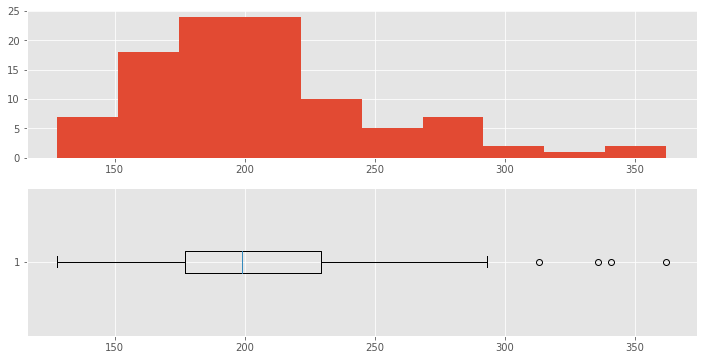

In [15]:
train1_fail = df1.groupby('id').cycle.max()

fig, axs = plt.subplots(2, figsize=(12,6))
axs[0].hist(train1_fail)
axs[1].boxplot(train1_fail, vert=False);

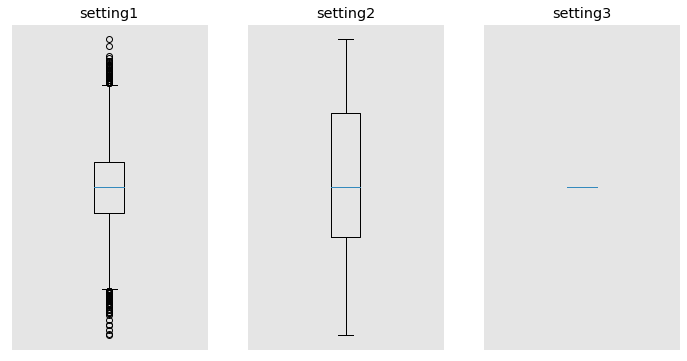

In [16]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
for i in range(3):
    axs[i].boxplot(df1.iloc[:,i+2])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'setting{i+1}')
fig.savefig('data/boxplot_settings')

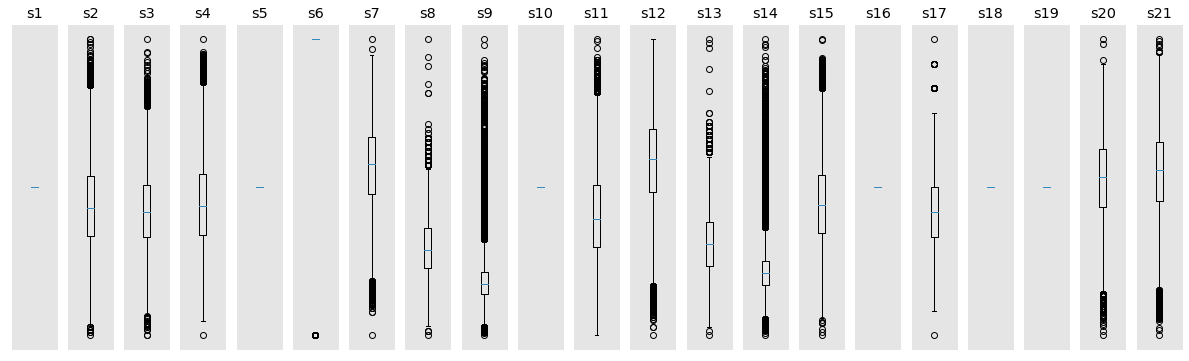

In [17]:
fig, axs = plt.subplots(1,21, figsize=(21,6))
for i in range(21):
    axs[i].boxplot(df1.iloc[:,i+5])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'{df1.columns[i+5]}')
plt.savefig('data/boxplot_sensors')

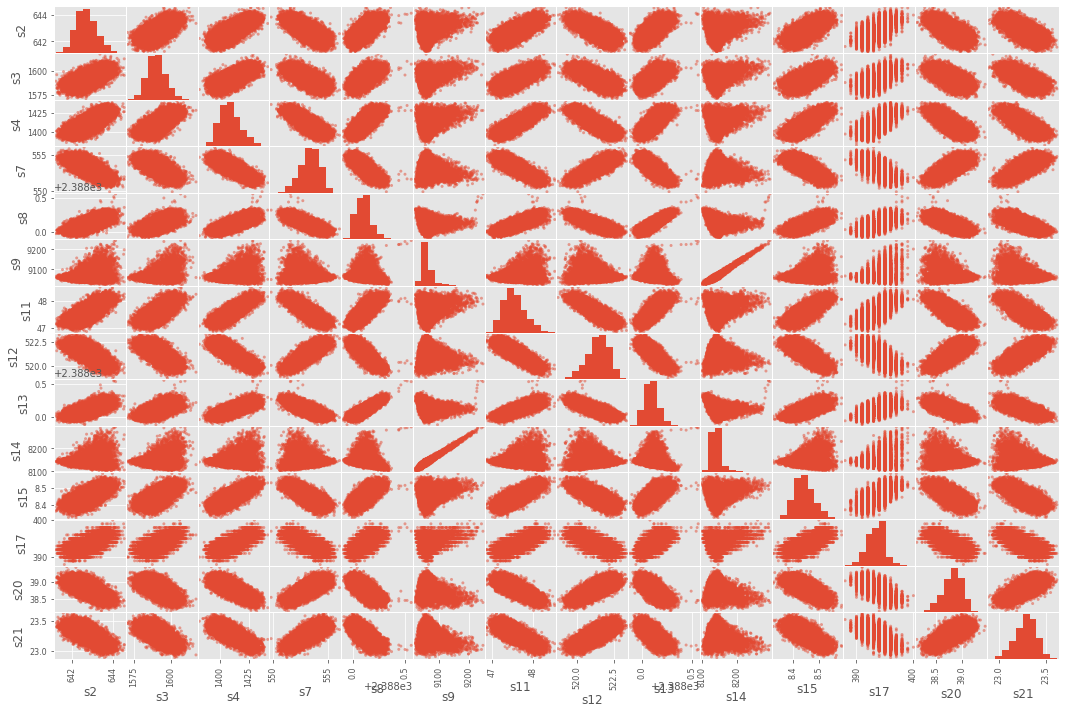

In [18]:
scatter_matrix(df1.iloc[:,np.r_[6,7,8,11,12,13,15,16,17,18,19,21,24,25]], figsize=(18,12));

In [19]:
q25 = pd.DataFrame(data=np.arange(51), columns=['RUL'])
q75 = pd.DataFrame(data=np.arange(51), columns=['RUL'])
sensor = [f's{i}' for i in range(1,22) ]
for s in sensor:
        q25.insert(len(q25.columns), f'{s}', df1[df1['RUL']<=50][s].groupby(df1['RUL']).quantile(0.25))
        q75.insert(len(q75.columns), f'{s}', df1[df1['RUL']<=50][s].groupby(df1['RUL']).quantile(0.75))
q25.set_index('RUL')

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
RUL,,,,,,,,,,,,,,,,,,,,,
0,518.67,643.5000,1599.2375,1428.0750,14.62,21.61,551.0150,2388.1800,9050.6175,1.3,48.0900,519.3950,2388.1975,8122.7500,8.513425,0.03,396.00,2388.0,100.0,38.3375,22.997975
1,518.67,643.4800,1599.0575,1426.1800,14.62,21.61,551.1375,2388.1900,9052.1825,1.3,48.1000,519.5275,2388.1875,8124.2450,8.511700,0.03,395.75,2388.0,100.0,38.3600,23.022775
2,518.67,643.4800,1599.7375,1426.0575,14.62,21.61,551.1750,2388.1800,9054.0100,1.3,48.0800,519.5075,2388.1900,8125.3375,8.510325,0.03,396.00,2388.0,100.0,38.3975,23.036975
3,518.67,643.3800,1598.8800,1426.0975,14.62,21.61,551.2575,2388.1700,9052.1325,1.3,48.0375,519.6025,2388.1800,8125.1350,8.509275,0.03,395.00,2388.0,100.0,38.3800,23.028725
4,518.67,643.4500,1600.3825,1424.1600,14.62,21.61,551.3300,2388.1600,9053.0225,1.3,48.0575,519.6625,2388.1700,8126.6875,8.503200,0.03,396.00,2388.0,100.0,38.4100,23.042500
5,518.67,643.3350,1597.8850,1424.7450,14.62,21.61,551.3175,2388.1700,9051.8475,1.3,48.0200,519.7075,2388.1600,8125.7825,8.500475,0.03,395.00,2388.0,100.0,38.4000,23.033050
6,518.67,643.3300,1598.0125,1423.1150,14.62,21.61,551.3975,2388.1575,9055.2200,1.3,48.0000,519.7700,2388.1500,8126.8700,8.497350,0.03,395.00,2388.0,100.0,38.4275,23.051100
7,518.67,643.3575,1597.4400,1422.4400,14.62,21.61,551.4200,2388.1675,9051.4100,1.3,47.9800,519.8350,2388.1675,8127.0300,8.493825,0.03,395.00,2388.0,100.0,38.4275,23.065925
8,518.67,643.3000,1597.8725,1422.7150,14.62,21.61,551.4875,2388.1500,9053.9675,1.3,47.9500,519.8175,2388.1600,8128.0800,8.492975,0.03,395.00,2388.0,100.0,38.4300,23.058400


In [32]:
eng_id3 = df2[df2['id'] == 3]
eng_id3.set_index('RUL')

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol,f30,f10,a1,sd1,max1,min1,incr1,dec1,a2,sd2,max2,min2,incr2,...,max15,min15,incr15,dec15,a16,sd16,max16,min16,incr16,dec16,a17,sd17,max17,min17,incr17,dec17,a18,sd18,max18,min18,incr18,dec18,a19,sd19,max19,min19,incr19,dec19,a20,sd20,max20,min20,incr20,dec20,a21,sd21,max21,min21,incr21,dec21
RUL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
115,3,64,0.0004,0.0001,100.0,518.67,642.53,1590.04,1404.68,14.62,21.61,553.90,2388.04,9061.33,1.3,47.24,522.24,2388.07,8143.14,8.4227,0.03,393,2388,100.0,39.13,23.3791,179,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.364,0.272731,642.73,641.80,0.564,...,8.4616,8.4032,0.01356,0.04484,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,392.7,1.159502,394.0,390.0,2.7,1.3,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.985714,0.120119,39.15,38.83,0.155714,0.164286,23.389325,0.021011,23.4182,23.3697,0.019625,0.028875
114,3,65,-0.0024,-0.0003,100.0,518.67,641.69,1586.21,1400.69,14.62,21.61,554.63,2388.03,9057.61,1.3,47.29,522.25,2387.98,8139.64,8.4379,0.03,392,2388,100.0,39.12,23.4958,179,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.292,0.344764,642.73,641.69,0.602,...,8.4616,8.4032,0.01600,0.04240,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,392.6,1.173788,394.0,390.0,2.6,1.4,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,39.002500,0.120919,39.15,38.83,0.172500,0.147500,23.410620,0.050975,23.4958,23.3697,0.040920,0.085180
113,3,66,-0.0003,0.0000,100.0,518.67,642.25,1577.22,1397.90,14.62,21.61,553.79,2388.01,9059.80,1.3,47.31,522.15,2388.03,8141.08,8.4032,0.03,391,2388,100.0,38.92,23.4320,179,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.244,0.308516,642.56,641.69,0.554,...,8.4616,8.4032,0.01590,0.04250,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,392.3,1.159502,394.0,390.0,2.3,1.7,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.993333,0.116404,39.15,38.83,0.163333,0.156667,23.414183,0.046422,23.4958,23.3697,0.044483,0.081617
112,3,67,-0.0040,-0.0005,100.0,518.67,642.00,1584.55,1403.87,14.62,21.61,553.84,2388.10,9060.70,1.3,47.29,521.81,2388.03,8139.27,8.4190,0.03,392,2388,100.0,39.04,23.4697,179,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.188,0.295327,642.53,641.69,0.498,...,8.4616,8.4032,0.01652,0.04188,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,392.3,1.159502,394.0,390.0,2.3,1.7,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.998000,0.110735,39.15,38.83,0.168000,0.152000,23.422114,0.047288,23.4958,23.3697,0.052414,0.073686
111,3,68,0.0034,-0.0002,100.0,518.67,642.94,1587.27,1400.37,14.62,21.61,554.43,2388.04,9056.56,1.3,47.31,522.14,2387.99,8141.67,8.4005,0.03,392,2388,100.0,39.08,23.3725,179,0,0,518.67,0.0,518.67,518.67,0.0,0.0,642.230,0.368571,642.94,641.69,0.540,...,8.4616,8.4005,0.01895,0.04215,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,392.3,1.159502,394.0,390.0,2.3,1.7,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,39.018000,0.104966,39.15,38.83,0.188000,0.132000,23.415913,0.047163,23.4958,23.3697,0.046212,0.079887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,3,175,-0.0030,0.0004,100.0,518.67,643.15,1603.74,1424.17,14.62,21.61,551.47,2388.06,9172.76,1.3,48.12,520.34,2388.14,8238.86,8.5066,0.03,396,2388,100.0,38.49,22.9909,179,2,1,518.67,0.0,518.67,518.67,0.0,0.0,643.387,0.223858,643.64,642.90,0.487,...,8.5363,8.4758,0.02625,0.03425,0.03,0.0,0.03,0.03,6.938894e-18,-6.938894e-18,395.3,0.674949,396.0,394.0,1.3,0.7,2388.0,0.0,2388.0,2388.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,0.0,38.577000,0.123832,38.85,38.48,0.097000,0.273000,23.134980,0.074652,23.2086,22.9909,0.144080,0.073620
3,3,176,-0.0008,0

In [34]:
eng_id3_50 = eng_id3[eng_id3['RUL'] <= eng_id3['RUL'].min() + 50]

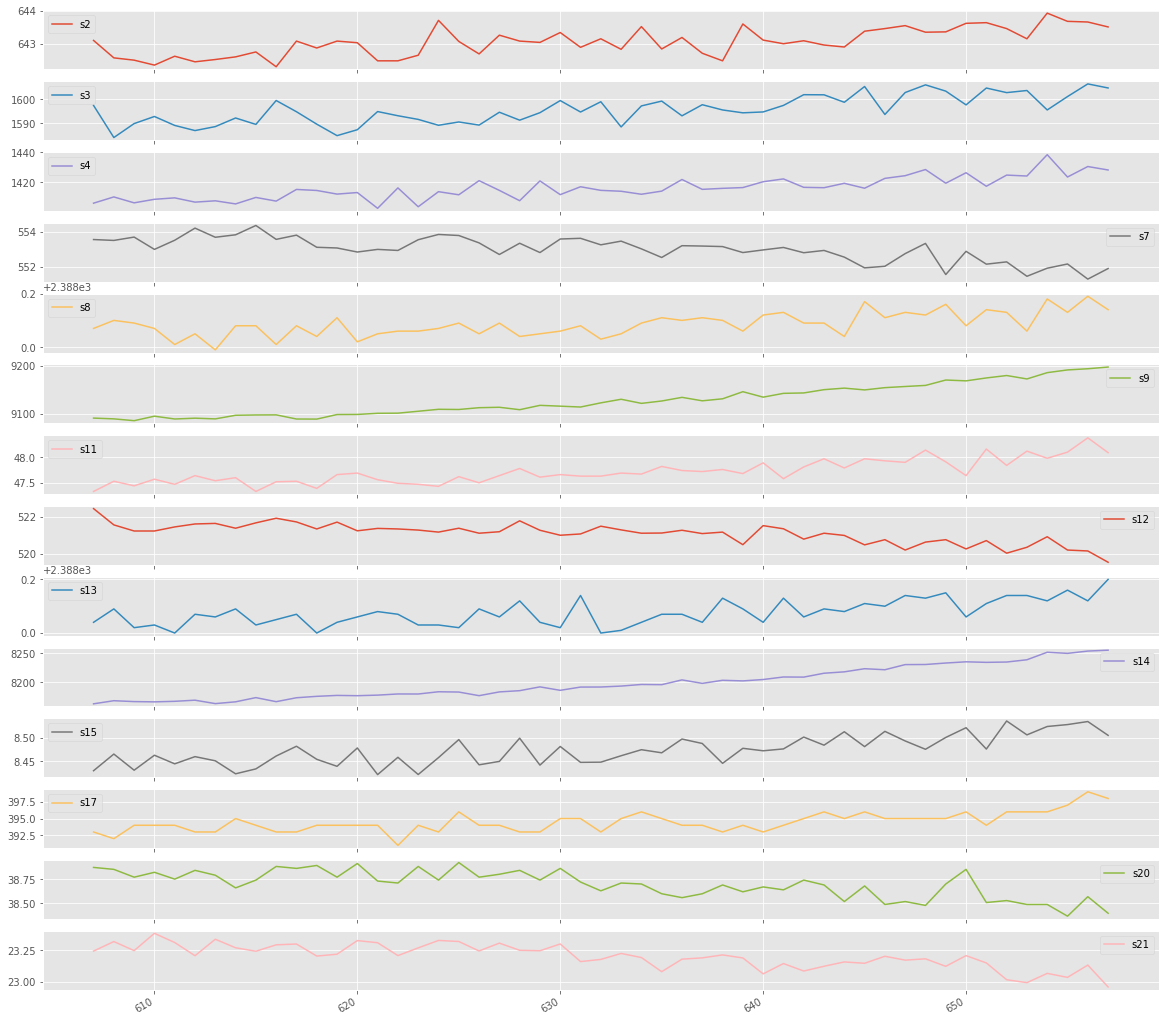

In [35]:
disp_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
cols1 = ['a2', 'a3', 'a4', 'a7', 'a8', 'a9', 'a11', 'a12', 'a13', 'a14', 'a15', 'a17', 'a20', 'a21']


# plotting sensor data for engine ID 3 prior to a failure point
eng_id3_50[disp_cols].plot(subplots=True, sharex=True, figsize=(20,20));



In [36]:
index = range(50,-1,-1)
anti_index = range(51)

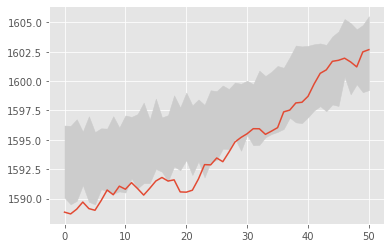

In [37]:
fig, ax = plt.subplots()
ax.plot(anti_index,eng_id3_50['a3'])
ax.fill_between(index, q25.s3.values.ravel(), q75.s3.values.ravel(), color='0.8')

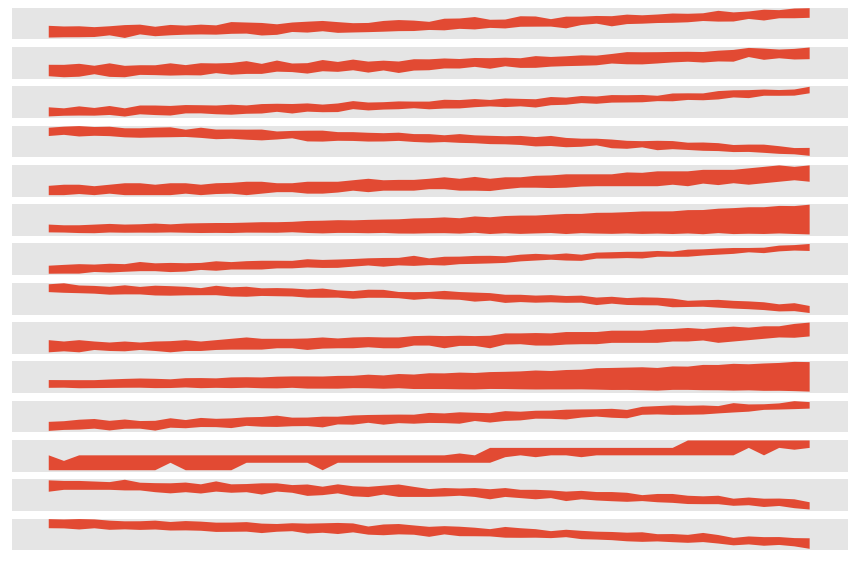

In [38]:
fig, ax = plt.subplots(len(disp_cols), figsize=(15,10))
for i, disp in enumerate(disp_cols):
  ax[i].fill_between(index, q25[disp].values.ravel(), q75[disp].values.ravel())
  # ax[i].plot(anti_index,eng_id3_50[disp], label=disp)
  ax[i].set_yticks([])
  ax[i].set_xticks([])
plt.savefig('data/trends')

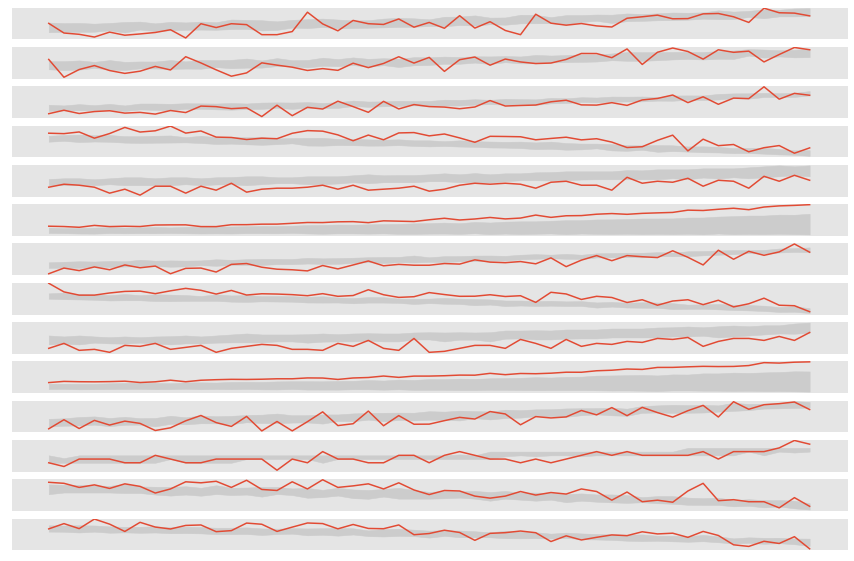

In [39]:
fig, ax = plt.subplots(len(disp_cols), figsize=(15,10))
for i, disp in enumerate(disp_cols):
  ax[i].fill_between(index, q25[disp].values.ravel(), q75[disp].values.ravel(), color='0.8')
  ax[i].plot(anti_index,eng_id3_50[disp], label=disp)
  ax[i].set_yticks([])
  ax[i].set_xticks([])
plt.savefig('data/compare_trends')

# Final cleaning of data

## Additional considered modifications of the data

`window_trending` adds columns to the dataframe, recording the average, standard deviation, increase and decrease over the previous rows for each sensor. 

In [12]:
df2 = window_trending(df1)

`window_avg_sd` is a simpler (earlier) version of `window_trending`, adding columns to the dataframe recording the average and standard deviation over the previous rows for each sensor. 

In [ ]:
# df3 = window_avg_sd(df1)

#### Trimming features
Not all columns are valuable

In [ ]:
reduced_cols = []

## Train/Test Split

In [40]:
df_train, df_test = tts(df1)
X, y_reg, y_clf, y_mclf = xy_split(df_train)
X_test, y_test_reg, y_test_clf, y_test_mclf = xy_split(df_test)

# Build models

## Linear Regression

In [41]:
reg = LinearRegression()

reg.fit(X, y_reg)
reg.score(X, y_reg)

0.6820778483762241

In [42]:
print(f'MSE: {mean_squared_error(y_reg, reg.predict(X))}')

MSE: 1599.0105277382333


In [43]:
reg.score(X_test, y_test_reg)

0.47815556815658583

## OLS with StatsModel

In [44]:
model = sm.OLS(y_reg, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     422.5
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:00:41   Log-Likelihood:                -19214.
No. Observations:                3762   AIC:                         3.847e+04
Df Residuals:                    3742   BIC:                         3.859e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
id             1.1963      0.031     38.589      0.0

## Logistics Regression

In [45]:
log = LogisticRegression(max_iter=10**6)

log.fit(X, y_clf)
y_pred = log.predict(X)
log.score(X, y_clf)
confusion_matrix(y_pred, y_clf)

array([[3518,   52],
       [  35,  157]])

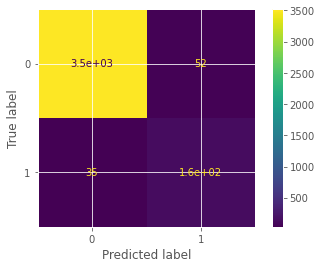

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_clf), display_labels=log.classes_)
disp.plot();

In [47]:
print(f'F1 score: {f1_score(y_clf, y_pred)}')
print(f'accuracy: {accuracy_score(y_clf, y_pred)}')
print(f'recall: {recall_score(y_clf, y_pred)}')
print(f'precision: {precision_score(y_clf, y_pred)}')

F1 score: 0.7830423940149626
accuracy: 0.9768740031897927
recall: 0.7511961722488039
precision: 0.8177083333333334


In [48]:
balanced_accuracy_score(y_clf, y_pred)

0.8706726709822685

## Random Forest classifier

In [62]:
clf = RandomForestClassifier()
clf.fit(X,y_mclf)
clf.score(X,y_mclf)

1.0

In [63]:
y_pred = clf.predict(X)

In [64]:
cm = confusion_matrix(y_pred, y_mclf)
cm

array([[3173,    0,    0],
       [   0,  380,    0],
       [   0,    0,  209]])

In [66]:
t0, f01, f02, f10, t1, f12, f20, f21, t2 = cm.ravel()
# print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')

In [67]:
clf.score(X_test,y_test_mclf)

0.9301677633528959

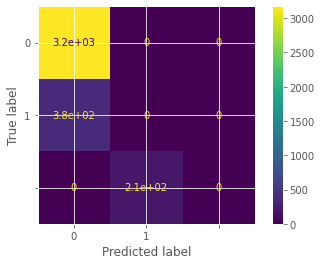

In [68]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_clf), display_labels=log.classes_)
disp.plot();

In [53]:
y_pred = clf.predict(X_test)
y_pred.reshape(1,-1)

array([[0, 0, 0, ..., 2, 2, 2]], dtype=int64)

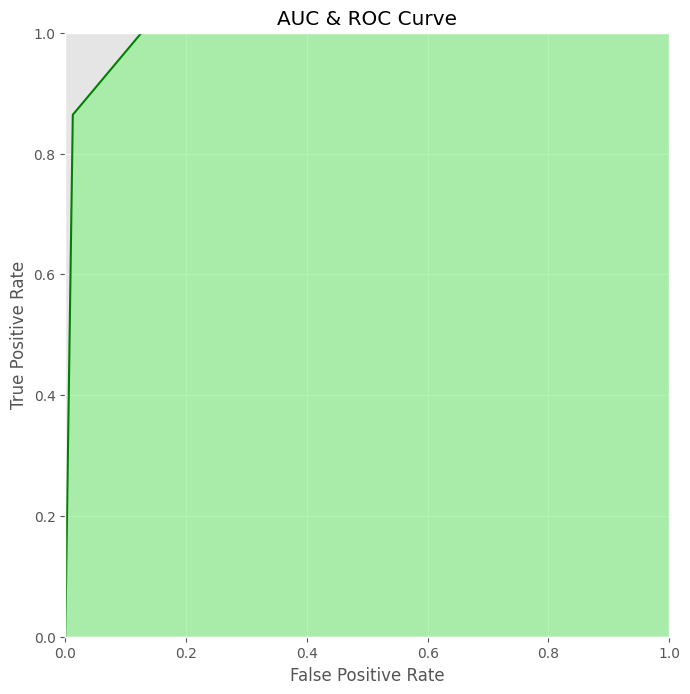

In [54]:
false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test_clf, y_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [56]:
tn, fp, fn, tp = cm.ravel()
print(f'F1 score: {2 * tp / (2* tp + fp +fn)}')
print(f'accuracy: { (tp + tn) / (tp +fn + fp + tn)}')
print(f'recall: { tp / (tp + fn)}')
print(f'precision: { tp / (tp + fp)}')

ValueError: ignored

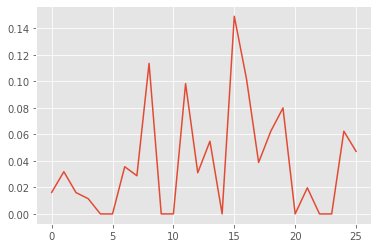

In [55]:
plt.plot(clf.feature_importances_)

## Random Forest Regressor

In [13]:
df_train, df_test = tts(df2[['id','cycle', 'setting1', 'setting2', 'a1', 'incr1', 'dec1', 
                             'a2', 'incr2', 'dec2', 'a3', 'incr3', 'dec3', 'a4', 'incr4', 'dec4', 
                             'a5', 'incr5', 'dec5', 'a6', 'incr6', 'dec6', 'a7', 'incr7', 'dec7', 
                             'a8', 'incr8', 'dec8', 'a9', 'incr9', 'dec9', 'a10', 'incr10', 'dec10',
                             'a11', 'incr11', 'dec11', 'a12', 'incr12', 'dec12', 'a13', 'incr13', 'dec13',
                             'a14', 'incr14', 'dec14', 'a15', 'incr15', 'dec15', 'a16', 'incr16', 'dec16', 
                             'a17', 'incr17', 'dec17', 'a18','incr18', 'dec18', 'a19', 'incr19', 'dec19', 
                             'a20',  'incr20', 'dec20', 'a21', 'incr21', 'dec21', 'RUL', 'f10', 'f30', 'eol']])
X, y_reg, y_clf, y_mclf = xy_split(df_train)
X_test, y_test_reg, y_test_clf, y_test_mclf = xy_split(df_test)

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum depth
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



In [15]:
clf_reg = RandomForestRegressor(oob_score=True, verbose=1)
rf_reg = RandomizedSearchCV(estimator = clf_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_reg.fit(X,y_reg)
rf_reg.score(X,y_reg)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 35.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.4s finished


0.9921765794775889

In [16]:
rf_reg.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1200}

In [17]:
y_pred = rf_reg.predict(X)
y_test_pred = rf_reg.predict(X_test)
rf_reg.score(X_test,y_test_reg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    1.2s finished


0.6472735710457072

In [18]:
np.sum(y_pred - y_reg.values) / len(y_pred - y_reg.values)

0.041988716964480206

In [19]:
len(y_pred)

2517

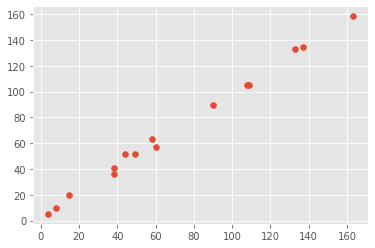

In [20]:
plt.scatter(y_reg[X['cycle']==150], y_pred[X['cycle']==150])

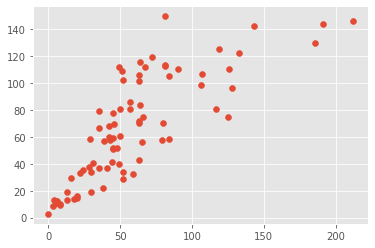

In [21]:
plt.scatter(y_test_reg[X_test['cycle']==150], y_test_pred[X_test['cycle']==150])

## Gradient Boosting Model



### Binary Classification with lightGBM

In [ ]:
lgb = LGBMClassifier(random_state=0, metric='auc')
lgb.fit(X, y_clf)
lgb.score(X, y_clf)

1.0

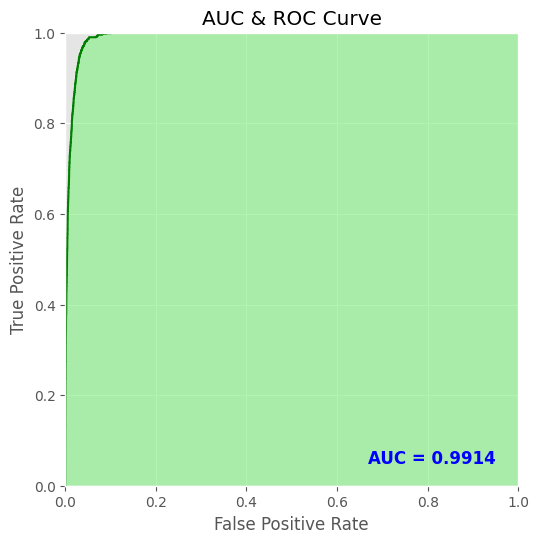

In [ ]:
y_pred = lgb.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test_clf, y_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test_clf, y_pred)

plt.figure(figsize=(6, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Regressor with sklearn

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X, y_reg)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred = gbr.predict(X)
gbr.score(X, y_reg)

0.9865793637298564

In [ ]:
gbr.predict(X_test)
gbr.score(X_test, y_test_reg)

0.5900809467986812

In [ ]:
gbr.feature_importances_

array([2.51853917e-01, 6.10220762e-01, 9.72968535e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.03401892e-03, 8.16589971e-04,
       4.14757441e-02, 0.00000000e+00, 2.18324972e-04, 3.42390638e-03,
       6.99971049e-04, 4.22898140e-03, 0.00000000e+00, 4.69570815e-02,
       8.19630015e-03, 2.72072491e-03, 5.40887679e-03, 9.96219741e-03,
       0.00000000e+00, 4.45120878e-03, 0.00000000e+00, 0.00000000e+00,
       4.38888630e-03, 3.84521184e-03])

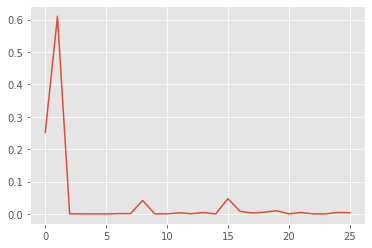

In [ ]:
plt.plot(gbr.feature_importances_)

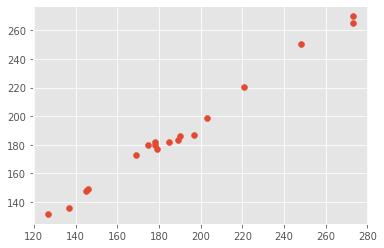

In [ ]:
plt.scatter(y_reg[X['cycle']==10], y_pred[X['cycle']==10])

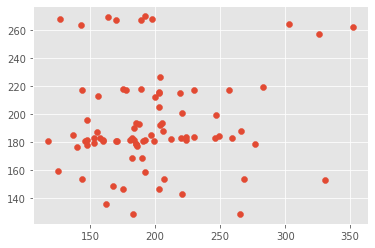

In [ ]:
plt.scatter(y_test_reg[X_test['cycle']==10], gbr.predict(X_test)[X_test['cycle']==10])

## Neural Networks with TensorFlow (LSTM) as Classifier

In [ ]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 3

In [ ]:
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

#### Generate sequences

In [ ]:
# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

In [ ]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

#### Generate labels

In [ ]:
# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['f10']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

#### Define LSTM network

In [ ]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_c = Sequential()

lstm_c.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=False))
# lstm_c.add(Dropout(0.2))

# lstm_c.add(LSTM(
#           units=50,
#           return_sequences=False))
# lstm_c.add(Dropout(0.2))

lstm_c.add(Dense(units=nb_out, activation='sigmoid'))
lstm_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

print(lstm_c.summary())

#### Train model

In [ ]:
# Train the network
lstm_c.fit(seq_array, label_array, epochs=30, batch_size=200, validation_split=0.10, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')])

# training metrics
scores = lstm_c.evaluate(seq_array, label_array, verbose=1, batch_size=200)
scores

#### Make predictions

In [ ]:
# make predictions and compute confusion matrix
y_pred = lstm_c.predict(seq_array) 

In [ ]:
y_true = label_array
y_true.ravel()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')

#### Confusion Matrix

In [ ]:
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot();


#### Performance measures

In [ ]:
print(f'F1 score: {2 * tp / (2* tp + fp +fn)}')
print(f'accuracy: { (tp + tn) / (tp +fn + fp + tn)}')
print(f'recall: { tp / (tp + fn)}')
print(f'precision: { tp / (tp + fp)}')

In [ ]:

# compute AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, y_pred)
print( f'auc = {auc}')

#### Data Checking and Fault Isolation

In [ ]:
len(next(seq_gen))

In [ ]:
eng_id3.shape

In [ ]:
eng = gen_sequence(eng_id3, 5, ["s1","s2","s3","s4","s5","s6"])

In [ ]:
next(eng)

In [ ]:
df1.id.value_counts().sort_values()

In [ ]:
df1[df1['id']==99]

In [ ]:
eng99 = gen_sequence(df1[df1['id']==99], 50, ['cycle',"s1","s2","s3","s4","s5","s6"])
next(eng99)

In [ ]:
label_array[130:200,:]

In [ ]:
np.sum(label_array)

In [ ]:
seq_array[0].shape

In [ ]:
seq_length

In [ ]:
len(y_pred)

In [ ]:
np.sum(y_pred)

## Neural Networks with TensorFlow (LSTM) as Regressor

#### Prepare model inputs

In [ ]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 3
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['RUL']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape



#### Define model

In [ ]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm = Sequential()

lstm.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=False))
# lstm.add(Dropout(0.2))

# lstm.add(LSTM(
#           units=50,
#           return_sequences=False))
# lstm.add(Dropout(0.2))

lstm.add(Dense(units=1, activation='linear'))
lstm.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True), metrics=['mse'])

print(lstm.summary())

#### Train model

In [ ]:
# Train the network
lstm.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.10, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=0, verbose=1, mode='auto')])
          # , callbacks.ReduceLROnPlateau()

# training metrics
scores = lstm.evaluate(seq_array, label_array, verbose=1, batch_size=200)
scores

#### Make predictions

In [ ]:
# make predictions 
y_pred = lstm.predict(seq_array) 
y_pred.shape

In [ ]:
y_pred

## 